## Семинар 8: "Снижение размерности"

ФИО: __Федотова Алёна Дмитриевна__

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/alcyone/scikit_learn_data


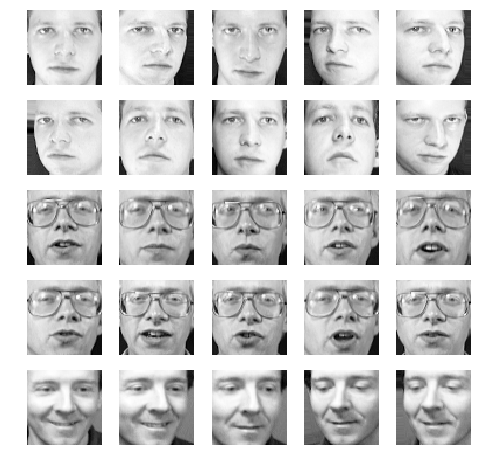

In [3]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [5]:
X.shape

(400, 4096)

In [6]:
model_pca = PCA(n_components=25)
model_pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
principle_components = model_pca.components_

In [8]:
principle_components.shape

(25, 4096)

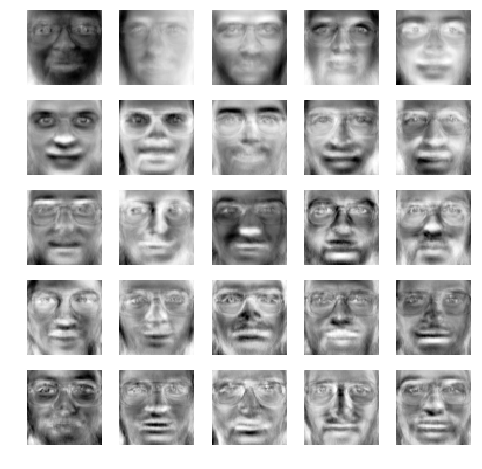

In [9]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(principle_components[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте метод <b>.explained\_variance\_ratio\_</b>

In [84]:
model_pca = PCA()
model_pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'Reconstruction quality (MSE)')

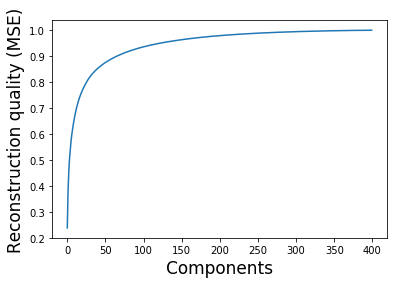

In [85]:
plt.plot(np.cumsum(model_pca.explained_variance_ratio_))
plt.xlabel('Components', fontsize=17)
plt.ylabel('Reconstruction quality (MSE)', fontsize=17)

In [12]:
model_pca = PCA(n_components=122)
model_pca.fit(X)
embedding = model_pca.transform(X)
reconstruction = model_pca.inverse_transform(embedding)

Text(0.5,1,'Error')

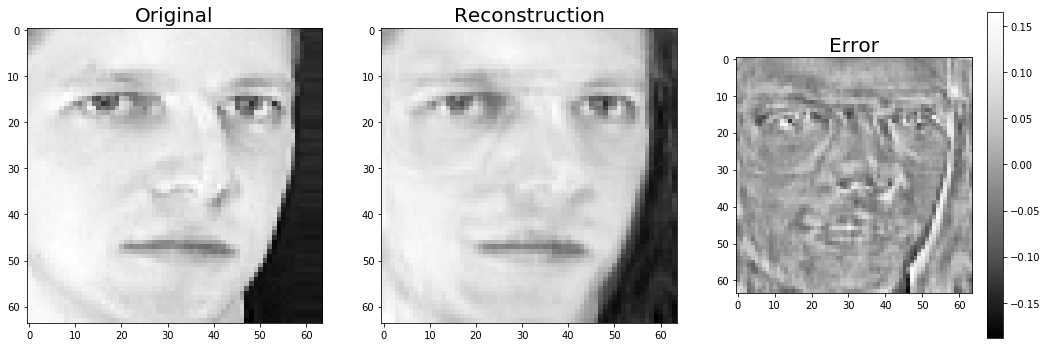

In [13]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow((X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Original', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow((reconstruction)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Reconstruction', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.title('Error', fontsize=20)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [14]:
model_pca = PCA(n_components=2)
model_pca.fit(X)
embedding = model_pca.transform(X)
reconstruction = model_pca.inverse_transform(embedding)

In [15]:
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

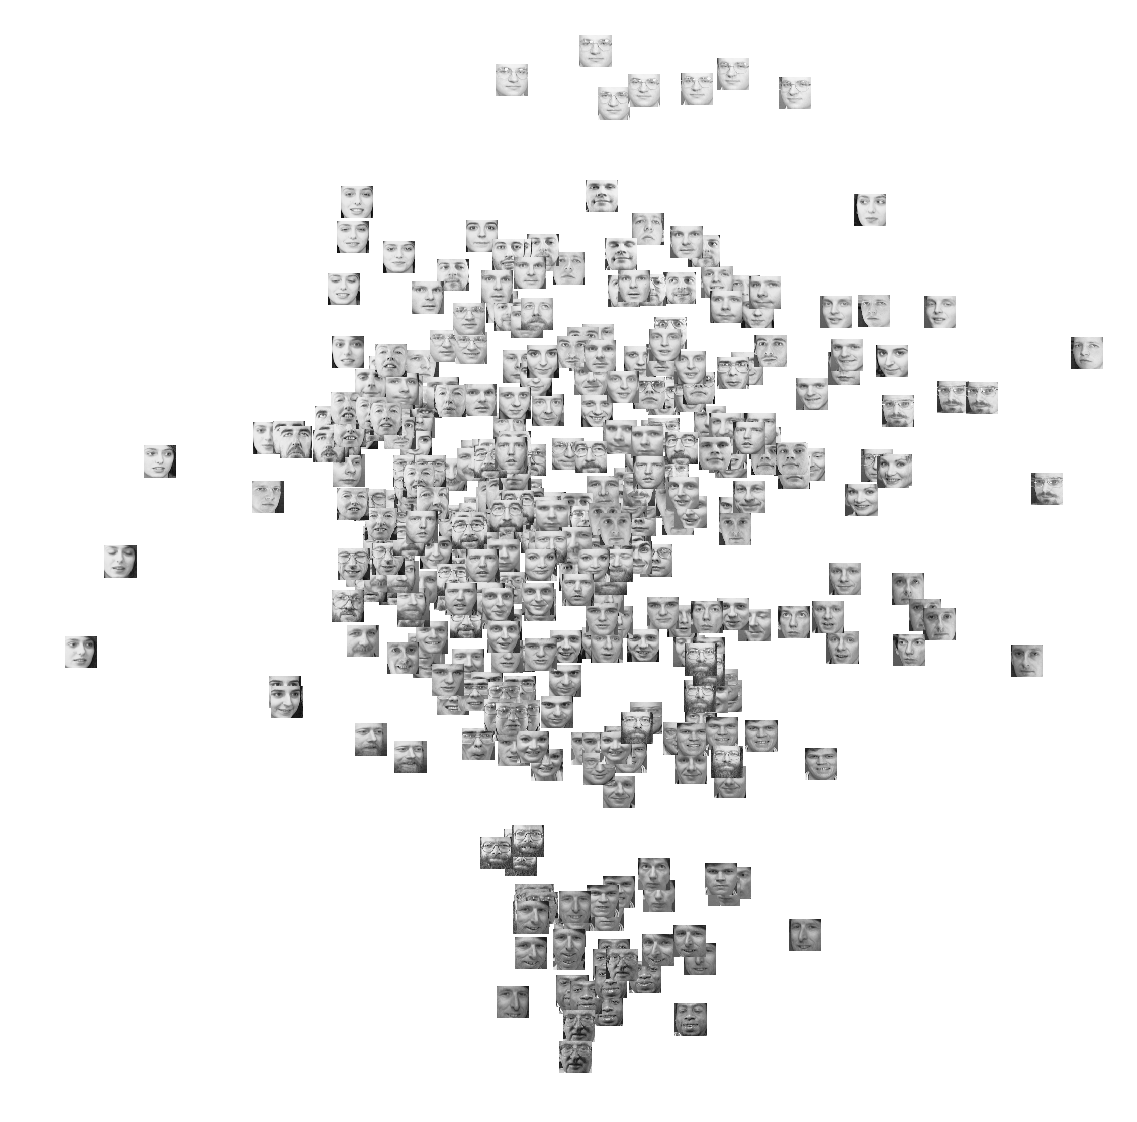

In [16]:
plot_dataset(X, embedding)

Первая компонента — освещение, вторая — в какую сторону смотрит человек

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [17]:
from torch.utils.data import DataLoader, Dataset

In [18]:
dataloader = DataLoader(X, batch_size=400, shuffle=True)

In [55]:
def fully_connected(arc, last_nonlinearity=True):
    layers = []
    for i in range(len(arc)-1):
        layers.append(nn.Linear(arc[i], arc[i+1]))
        if i != len(arc)-2 or last_nonlinearity:
            layers.append(nn.Sigmoid())
            layers.append(nn.BatchNorm1d(arc[i + 1]))
    return nn.Sequential(*layers)

In [56]:
fully_connected([4096, 200, 10], last_nonlinearity=False)

Sequential(
  (0): Linear(in_features=4096, out_features=200, bias=True)
  (1): Sigmoid()
  (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=200, out_features=10, bias=True)
)

In [57]:
class AE(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AE, self).__init__()
        # create encoder:
        self.encoder = fully_connected(arc_encoder, last_nonlinearity=False)
        self.decoder = fully_connected(arc_decoder, last_nonlinearity=False)
        
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [58]:
model = AE([4096, 200, 10], [10, 200, 4096])

In [59]:
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=200, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=4096, bias=True)
  )
)

In [60]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [61]:
import sys

In [62]:
for epoch in range(200):
    losses = []
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


 0.007902174256742194

In [63]:
embedding = model.encoder(Variable(torch.Tensor(X))).data.numpy()

In [64]:
reconstruction = model(Variable(torch.Tensor(X))).data.numpy()

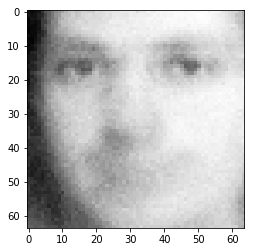

In [68]:
plt.imshow(reconstruction[3].reshape(64, 64), cmap=plt.cm.Greys_r)

<i> 2.2 Какое качество восстановления удалось получить?</i>

In [78]:
1 - np.mean(losses) / (X ** 2).mean()

0.97598247043788433

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [79]:
LOSS = []

for i in range(1, 200, 5):
    model = AE([4096, 200, i], [i, 200, 4096])
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(200):
        losses = []
        for x in dataloader:
            x_batch = Variable(x)
            y_batch = Variable(x, requires_grad=False)
            model.zero_grad()
            x_reconstruction = model(x_batch)
            loss_batch = loss(x_reconstruction, y_batch)
            loss_batch.backward()
            optimizer.step()
            losses.append(loss_batch.data[0])
        sys.stdout.write('\r {}'.format(np.mean(losses)))
    sys.stdout.write('\r {}\n'.format(np.mean(losses)))
    LOSS.append(np.mean(losses))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 0.014622852206230164
 0.008673759177327156
 0.007972744293510914
 0.007651254069060087
 0.0074370237998664385
 0.0072803390212357044
 0.0074859545566141605
 0.0071995672769844535
 0.0074688564054667955
 0.0073080831207334995
 0.0073914215900003916
 0.0071107754483819014
 0.007504968438297513
 0.0069434023462235936
 0.0070690466091036824
 0.0070219859480857855
 0.0070518320426344875
 0.0072425701655447485
 0.0072983475401997576
 0.0070739467628300195
 0.0071533760055899625
 0.0074124126695096495
 0.0071659237146377566
 0.0082589266821742065
 0.0070640281774103646
 0.0068497373722493656
 0.0072307121008634575
 0.0071492828428745275
 0.0073051890358328825
 0.0069013605825603015
 0.0076072113588452344
 0.0071457885205745795
 0.0070861484855413445
 0.0071352482773363595
 0.0073429872281849384
 0.0070236171595752246
 0.0070773535408079625
 0.0071891113184392455
 0.0070886742323637015
 0.0070880288258194926


In [80]:
LOSS_2 = LOSS

In [81]:
LOSS_1 = []

for i in range(1, 6):
    model = AE([4096, 200, i], [i, 200, 4096])
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(200):
        losses = []
        for x in dataloader:
            x_batch = Variable(x)
            y_batch = Variable(x, requires_grad=False)
            model.zero_grad()
            x_reconstruction = model(x_batch)
            loss_batch = loss(x_reconstruction, y_batch)
            loss_batch.backward()
            optimizer.step()
            losses.append(loss_batch.data[0])
        sys.stdout.write('\r {}'.format(np.mean(losses)))
    sys.stdout.write('\r {}\n'.format(np.mean(losses)))
    LOSS_1.append(np.mean(losses))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 0.014666673727333546
 0.011961801908910275
 0.010436025448143482
 0.009485252201557166
 0.008968321606516838


In [89]:
LOSS_3 = []

for i in range(200, 400, 20):
    model = AE([4096, 200, i], [i, 200, 4096])
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(200):
        losses = []
        for x in dataloader:
            x_batch = Variable(x)
            y_batch = Variable(x, requires_grad=False)
            model.zero_grad()
            x_reconstruction = model(x_batch)
            loss_batch = loss(x_reconstruction, y_batch)
            loss_batch.backward()
            optimizer.step()
            losses.append(loss_batch.data[0])
        sys.stdout.write('\r {}'.format(np.mean(losses)))
    sys.stdout.write('\r {}\n'.format(np.mean(losses)))
    LOSS_3.append(np.mean(losses))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 0.0068639824166893965
 0.0069953938946127895
 0.0071437368169426925
 0.0075546102598309525
 0.007153471000492573
 0.0071098818443715576
 0.0071810027584433556
 0.0070237834006547935
 0.0068807709030807025
 0.0069215805269777775


In [90]:
LOSS = LOSS_1 + LOSS_2[1:] + LOSS_3

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

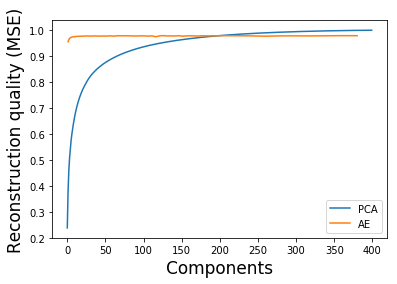

In [91]:
X_1 = list(range(1, 6))
X_2 = list(range(1, 200, 5))
X_3 = list(range(200, 400, 20))
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), label='PCA')
plt.plot(X_1 + X_2[1:] + X_3, 1 - LOSS / (X ** 2).mean(), label='AE')
plt.xlabel('Components', fontsize=17)
plt.ylabel('Reconstruction quality (MSE)', fontsize=17)
plt.legend()

Видно, что при небольшом количестве размерностей автоэнкодер работает лучше. Однако когда размерностей много, лучше оказывается РСА.

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [92]:
model = AE([4096, 200, 2], [2, 200, 4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(200):
    losses = []
    for x in dataloader:
        x_batch = Variable(x)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_reconstruction = model(x_batch)
        loss_batch = loss(x_reconstruction, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {}'.format(np.mean(losses)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


 0.011935724876821041

In [113]:
embedding = model.encoder(torch.from_numpy(X))
embedding.shape

torch.Size([400, 2])

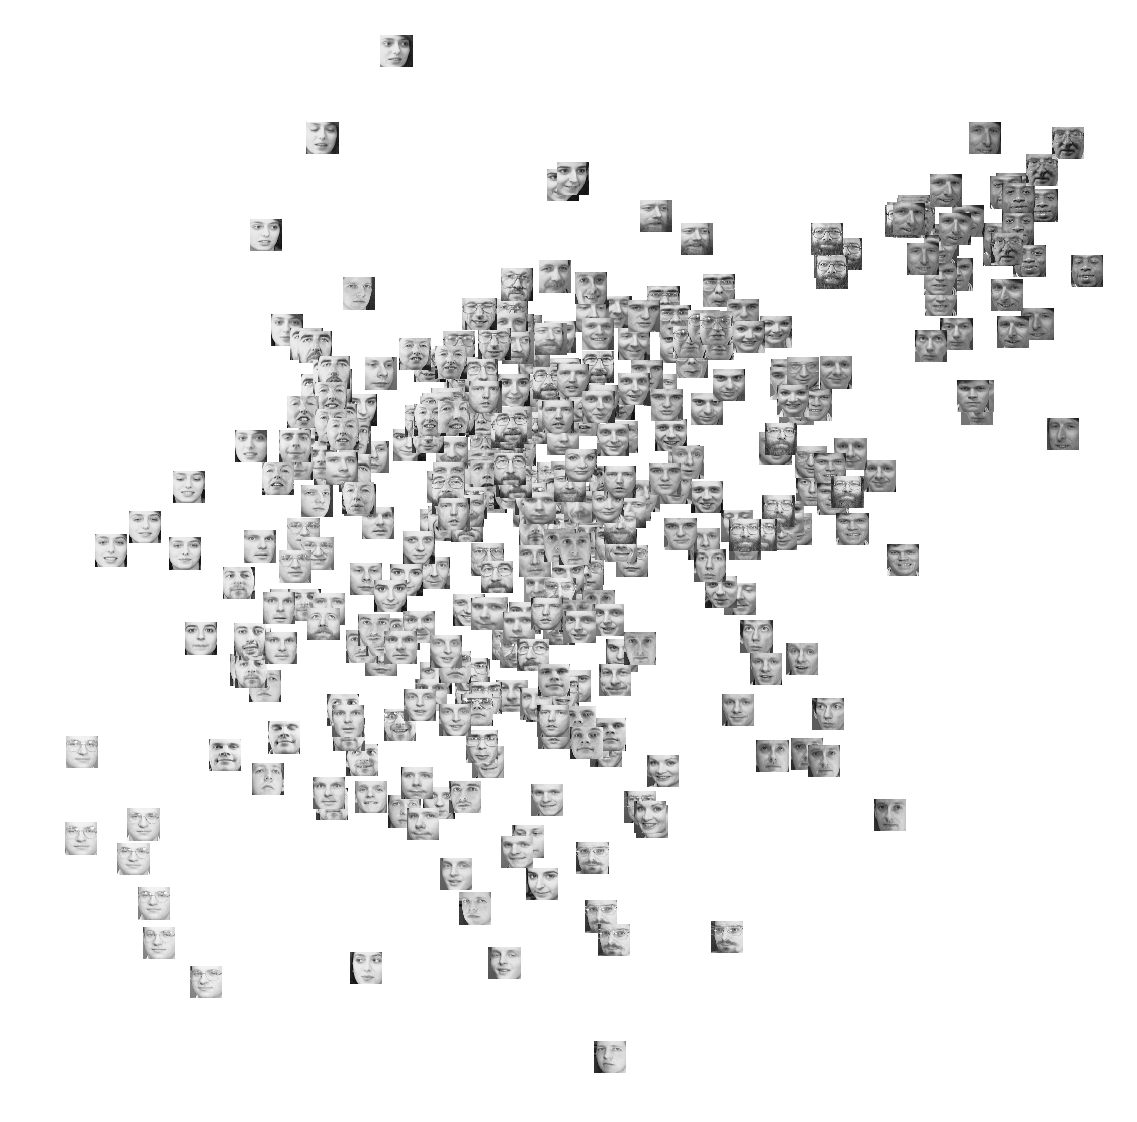

In [116]:
plot_dataset(X, embedding.data.numpy())

Аналогично случаю в РСА - по одной оси светлее-темнее, по другой - поворот головы (примерно). 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: